Using device: cuda
Loading datasets...
Loaded 16108 images for Train split
Loaded 14518 images for Test split
Training samples: 16108
Test samples: 14518

Initializing ResNet50 model...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]



STARTING RESNET50 TRAINING

Training ResNet50 with Early Stopping (patience=5)


Epoch 1/20 [Val]: 100%|██████████| 454/454 [01:29<00:00,  5.06it/s, loss=1.21, acc=63.8] 


✓ New best model saved with accuracy: 63.76%
Epoch 1: Train Loss: 1.0484, Train Acc: 60.16% | Val Loss: 1.2114, Val Acc: 63.76%


Epoch 2/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.54it/s, loss=1.22, acc=65.3] 


✓ New best model saved with accuracy: 65.27%
Epoch 2: Train Loss: 0.8262, Train Acc: 69.23% | Val Loss: 1.2176, Val Acc: 65.27%
EarlyStopping counter: 1 out of 5


Epoch 3/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.54it/s, loss=1.09, acc=68.5] 


✓ New best model saved with accuracy: 68.48%
Epoch 3: Train Loss: 0.7549, Train Acc: 72.08% | Val Loss: 1.0901, Val Acc: 68.48%


Epoch 4/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.51it/s, loss=1.25, acc=68.9] 


✓ New best model saved with accuracy: 68.93%
Epoch 4: Train Loss: 0.6917, Train Acc: 74.87% | Val Loss: 1.2514, Val Acc: 68.93%
EarlyStopping counter: 1 out of 5


Epoch 5/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.55it/s, loss=1.15, acc=69.8] 


✓ New best model saved with accuracy: 69.77%
Epoch 5: Train Loss: 0.6391, Train Acc: 76.82% | Val Loss: 1.1458, Val Acc: 69.77%
EarlyStopping counter: 2 out of 5


Epoch 6/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.51it/s, loss=1.11, acc=69]   


Epoch 6: Train Loss: 0.5736, Train Acc: 79.21% | Val Loss: 1.1090, Val Acc: 69.03%
EarlyStopping counter: 3 out of 5


Epoch 7/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.48it/s, loss=1.24, acc=70.4] 


✓ New best model saved with accuracy: 70.42%
Epoch 7: Train Loss: 0.5188, Train Acc: 81.40% | Val Loss: 1.2396, Val Acc: 70.42%
EarlyStopping counter: 4 out of 5


Epoch 8/20 [Val]: 100%|██████████| 454/454 [00:47<00:00,  9.54it/s, loss=1.35, acc=71]   


✓ New best model saved with accuracy: 70.96%
Epoch 8: Train Loss: 0.3685, Train Acc: 87.03% | Val Loss: 1.3511, Val Acc: 70.96%
EarlyStopping counter: 5 out of 5

⚠️ Early stopping triggered at epoch 8

📊 Loading best model for final evaluation...


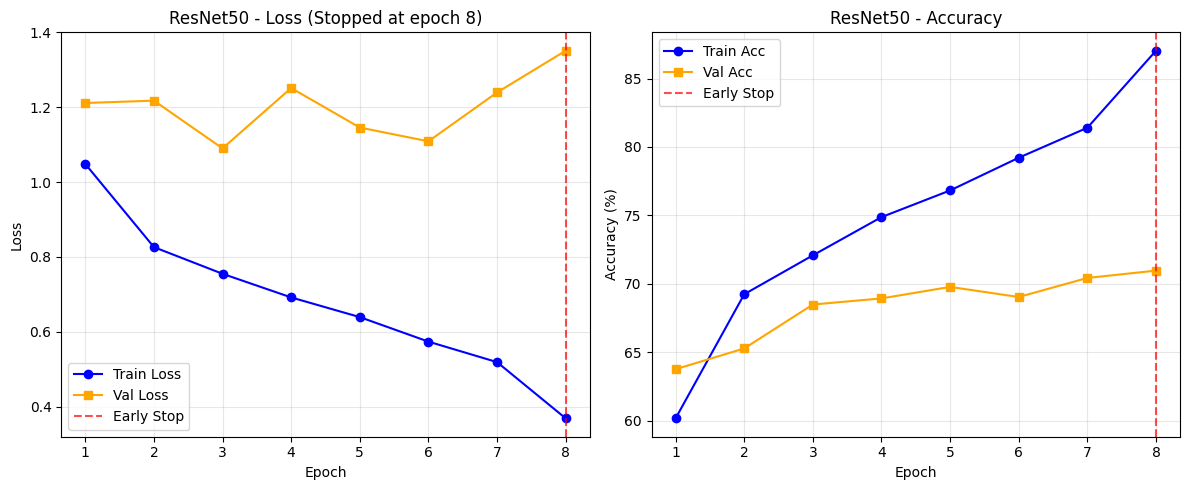

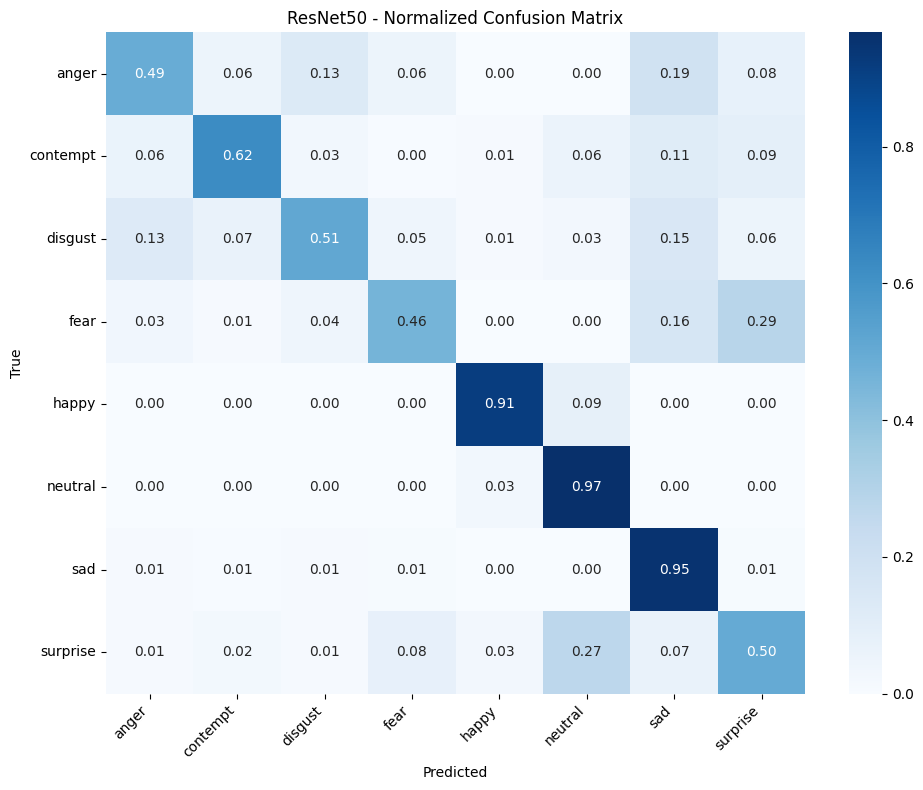


RESNET50 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       anger     0.7097    0.4924    0.5814      1718
    contempt     0.7548    0.6242    0.6834      1312
     disgust     0.6286    0.5112    0.5639      1248
        fear     0.7002    0.4603    0.5555      1664
       happy     0.9360    0.9146    0.9252      2704
     neutral     0.7268    0.9671    0.8299      2368
         sad     0.5872    0.9527    0.7265      1584
    surprise     0.5432    0.5005    0.5210      1920

    accuracy                         0.7096     14518
   macro avg     0.6983    0.6779    0.6733     14518
weighted avg     0.7153    0.7096    0.6985     14518


📈 Detailed Analysis for ResNet50:

Emotion         Accuracy       
------------------------------
anger           49.24%
contempt        62.42%
disgust         51.12%
fear            46.03%
happy           91.46%
neutral         96.71%
sad             95.27%
surprise        50.05%

✅ Best performing emotion: neutra

In [1]:
# Notebook 1: ResNet50 Model for AffectNet Emotion Recognition
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Constants
EMOTIONS = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
IMG_SIZE = 224

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Custom Dataset class
class AffectNetDataset(Dataset):
    def __init__(self, root_dir, split='Train', transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        
        split_path = self.root_dir / split
        if split_path.exists():
            for emotion_idx, emotion in enumerate(EMOTIONS):
                emotion_path = split_path / emotion
                if emotion_path.exists():
                    for img_path in emotion_path.glob('*.*'):
                        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                            self.images.append(img_path)
                            self.labels.append(emotion_idx)
        
        print(f"Loaded {len(self.images)} images for {split} split")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = "/kaggle/input/datasets/bouyassine11/affectnetcoorect/archive (3)"

print("Loading datasets...")
train_dataset = AffectNetDataset(data_dir, split='Train', transform=train_transform)
test_dataset = AffectNetDataset(data_dir, split='Test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize ResNet50 model
print("\nInitializing ResNet50 model...")
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, NUM_CLASSES)
resnet50 = resnet50.to(device)

# Training function with early stopping
def train_resnet50(model, model_name, train_loader, test_loader, epochs=EPOCHS, patience=5):
    print(f"\n{'='*50}")
    print(f"Training {model_name} with Early Stopping (patience={patience})")
    print('='*50)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    stopped_epoch = epochs
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({'loss': running_loss/(len(train_pbar)), 
                                   'acc': 100.*correct/total})
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({'loss': val_loss/(len(val_pbar)), 
                                     'acc': 100.*correct/total})
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print(f"✓ New best model saved with accuracy: {val_acc:.2f}%")
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            stopped_epoch = epoch + 1
            break
    
    # Final evaluation with best model
    print(f"\n📊 Loading best model for final evaluation...")
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'predictions': all_preds,
        'true_labels': all_labels,
        'stopped_epoch': stopped_epoch
    }

# Train ResNet50
print("\n" + "="*60)
print("STARTING RESNET50 TRAINING")
print("="*60)

resnet50_results = train_resnet50(resnet50, 'ResNet50', train_loader, test_loader, patience=5)

# Plotting results for ResNet50
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

epochs_range = range(1, len(resnet50_results['train_losses']) + 1)

# Plot losses
axes[0].plot(epochs_range, resnet50_results['train_losses'], label='Train Loss', marker='o', color='blue')
axes[0].plot(epochs_range, resnet50_results['val_losses'], label='Val Loss', marker='s', color='orange')
axes[0].axvline(x=resnet50_results['stopped_epoch'], color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[0].set_title(f'ResNet50 - Loss (Stopped at epoch {resnet50_results["stopped_epoch"]})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracies
axes[1].plot(epochs_range, resnet50_results['train_accs'], label='Train Acc', marker='o', color='blue')
axes[1].plot(epochs_range, resnet50_results['val_accs'], label='Val Acc', marker='s', color='orange')
axes[1].axvline(x=resnet50_results['stopped_epoch'], color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[1].set_title('ResNet50 - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix for ResNet50
plt.figure(figsize=(10, 8))
cm = confusion_matrix(resnet50_results['true_labels'], resnet50_results['predictions'])

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('ResNet50 - Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report for ResNet50
print("\n" + "="*60)
print("RESNET50 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(resnet50_results['true_labels'], resnet50_results['predictions'], 
                           target_names=EMOTIONS, zero_division=0, digits=4))

# Per-class performance analysis
print(f"\n📈 Detailed Analysis for ResNet50:")
cm = confusion_matrix(resnet50_results['true_labels'], resnet50_results['predictions'])

# Calculate per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print(f"\n{'Emotion':<15} {'Accuracy':<15}")
print("-"*30)
for emotion, acc in zip(EMOTIONS, class_acc):
    print(f"{emotion:<15} {acc*100:.2f}%")

# Find easiest and hardest emotions
best_class_idx = np.argmax(class_acc)
worst_class_idx = np.argmin(class_acc)
print(f"\n✅ Best performing emotion: {EMOTIONS[best_class_idx]} ({class_acc[best_class_idx]*100:.2f}%)")
print(f"❌ Worst performing emotion: {EMOTIONS[worst_class_idx]} ({class_acc[worst_class_idx]*100:.2f}%)")

# Save results
print(f"\n📁 ResNet50 results saved to 'resnet50_results.csv'")
print(f"   Best validation accuracy: {resnet50_results['best_val_acc']:.2f}%")
print(f"   Stopped at epoch: {resnet50_results['stopped_epoch']}")
print(f"   Total epochs trained: {len(resnet50_results['train_accs'])}")